<center>
<h1 style="color:red; font-size:70px;"> First Try</h1>

In questo notebook è riportato un primo approccio allo studio del dataset FER-2013. Il modello sviluppato è estremamente semplice (fin troppo), e non è in grado di fornire dei risultati adeguatamente robusti.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow import keras
from keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Rescaling, MaxPooling2D, Conv2D, Dropout

## Studio del dataset

In [2]:
trDir = "../Dataset/train"  
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Dataset di training (80%)
trDat = datagen.flow_from_directory(
    trDir,
    target_size=(48, 48),
    batch_size=32,
    class_mode="categorical",
    subset="training",     
    shuffle=True
)

# Dataset di validazione (20%)
valDat = datagen.flow_from_directory(
    trDir,
    target_size=(48, 48),
    batch_size=32,
    class_mode="categorical",
    subset="validation",   
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


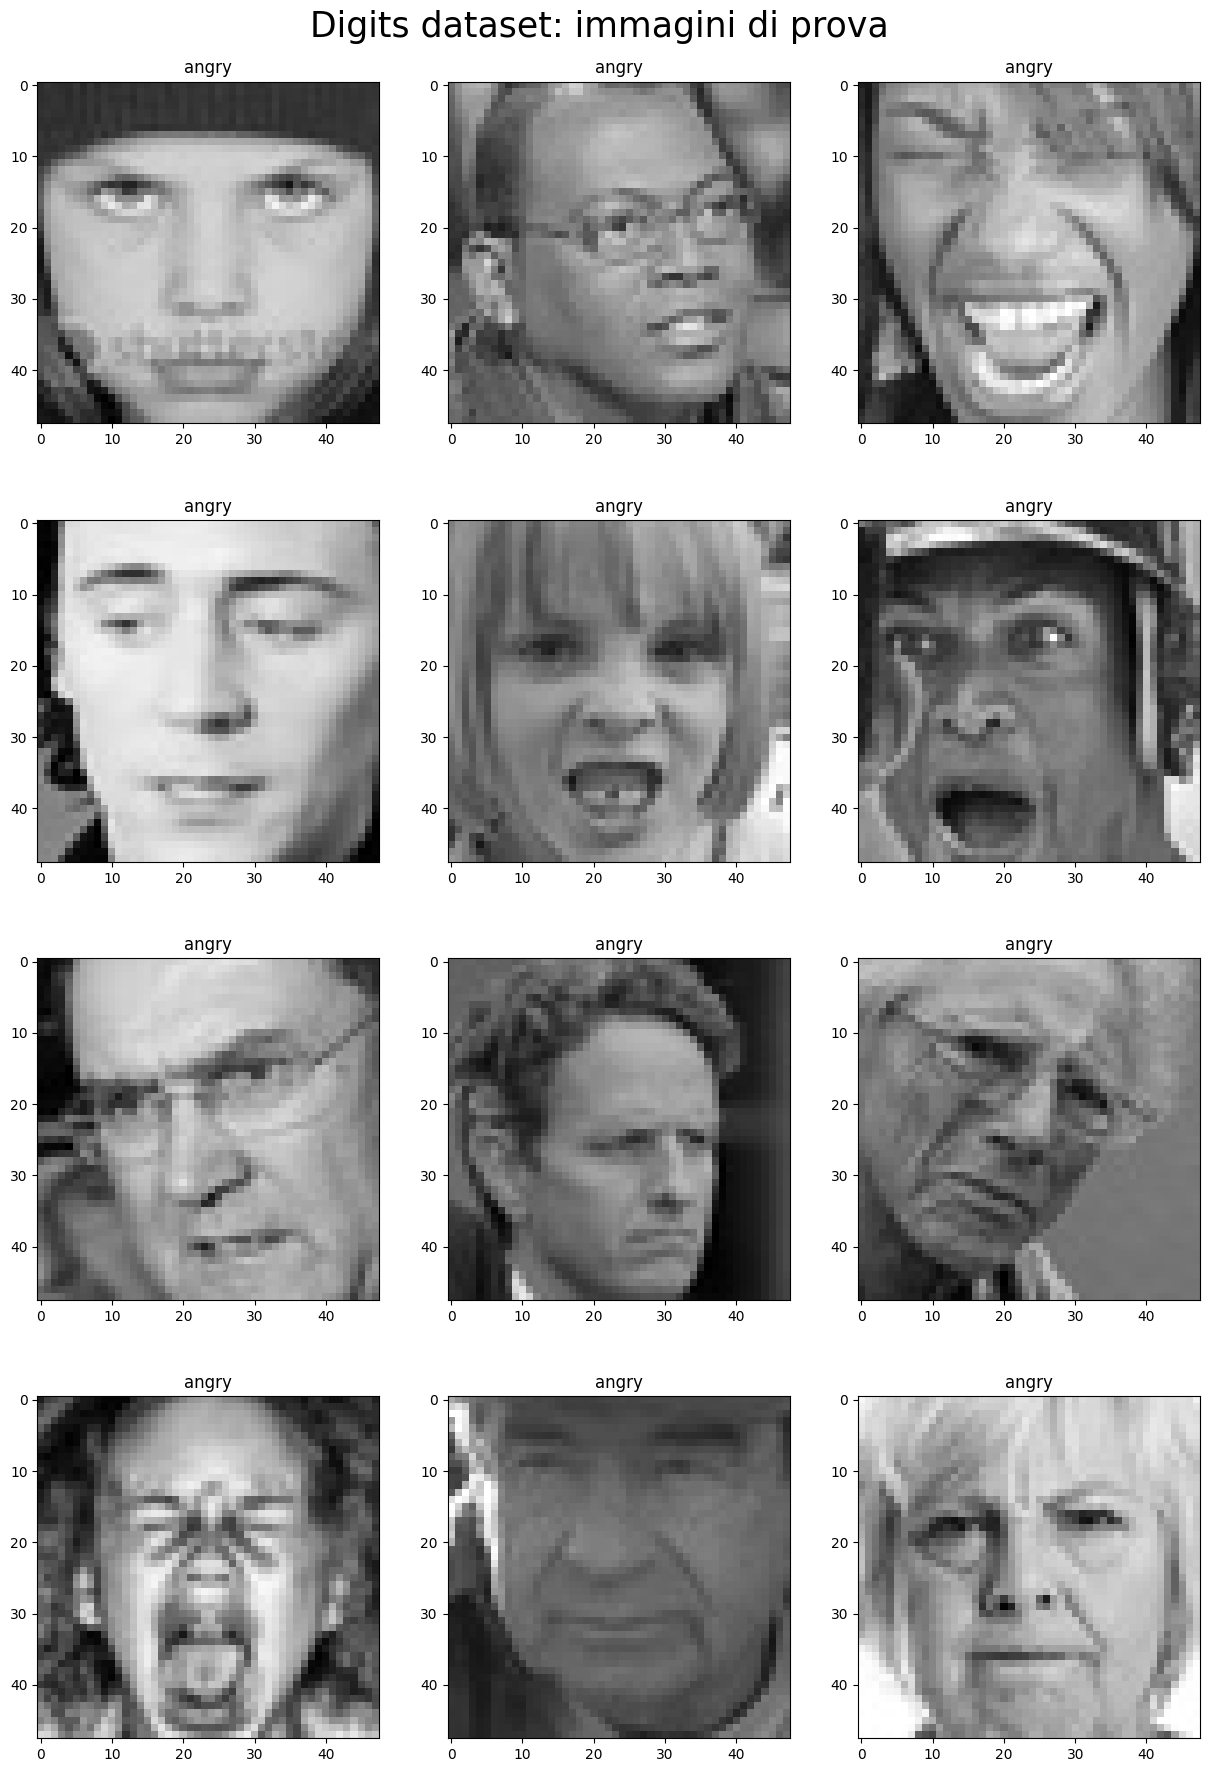

In [4]:
# Funzione per visualizzare alcuni elementi appartenenti al dataset
def studyDat(img, lab, classes):
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            ax[i][j].imshow(img[5*i+j])
            ax[i][j].set_title(classes[np.argmax(lab[5*i+j])])

    fig.suptitle("Digits dataset: immagini di prova", fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


cls = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
img, lab = next(valDat)
studyDat(img, lab, cls)

## Costruzione della rete

In [7]:
# Funzione per la costruzione del modello
def buildMod(imW, imH, numcl):

    model = Sequential()
    model.add(Input(shape=(imW, imH, 3)))

    # Parte con i filtri convoluzionali
    model.add(Conv2D(16, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())

    # Parte di classificazione
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(numcl, activation = 'softmax'))

    return model



model = buildMod(48, 48, 7)
plot_model(model, to_file="../Immagini/Architettura/iniziale.png", show_shapes=True, show_layer_names=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,527 (1.22 MB)

 Trainable params: 319,527 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

## Allenamento del modello

In [8]:
# Allenamento del modello
earlyS = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(trDat, epochs=200, validation_data=valDat, callbacks=[earlyS])

/home/filippo/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
718/718 ━━━━━━━━━━━━━━━━━━━━ 190s 260ms/step - accuracy: 0.2582 - loss: 1.8055 - val_accuracy: 0.3846 - val_loss: 1.5726
Epoch 2/200
718/718 ━━━━━━━━━━━━━━━━━━━━ 106s 147ms/step - accuracy: 0.3950 - loss: 1.5586 - val_accuracy: 0.4609 - val_loss: 1.4072
Epoch 3/200
718/718 ━━━━━━━━━━━━━━━━━━━━ 106s 147ms/step - accuracy: 0.4601 - loss: 1.4055 - val_accuracy: 0.4879 - val_loss: 1.3179
Epoch 4/200
718/718 ━━━━━━━━━━━━━━━━━━━━ 111s 154ms/step - accuracy: 0.5030 - loss: 1.3050 - val_accuracy: 0.5130 - val_loss: 1.2760
Epoch 5/200
102/718 ━━━━━━━━━━━━━━━━━━━━ 2:07 207ms/step - accuracy: 0.5485 - loss: 1.2285

KeyboardInterrupt: 

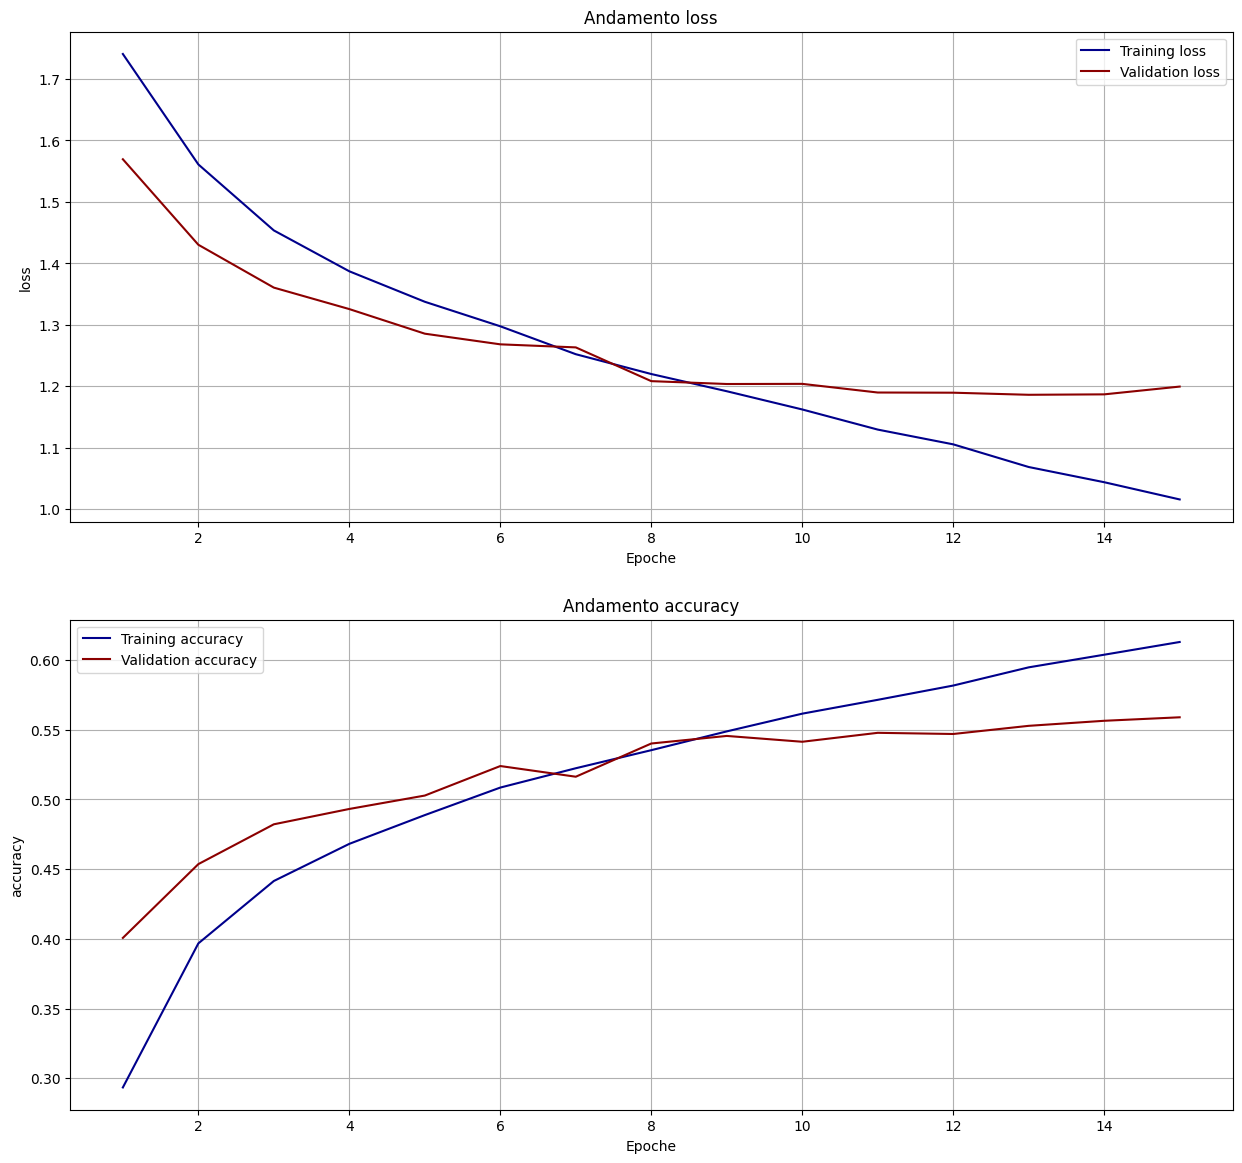

In [ ]:
def plotTrInfo(hist):
    # Funzione per graficare l'evoluzione di loss ed accuracy in fase di allenamento
    fig, ax = plt.subplots(2, 1, figsize=(15,14))

    dim = len(hist.history['loss'])
    lab = ['loss', 'accuracy']

    for i, l in enumerate(lab):
        ax[i].plot(np.linspace(1, dim, dim), hist.history[l], color = 'darkblue', label = "Training " + l)
        ax[i].plot(np.linspace(1, dim, dim), hist.history['val_'+l], color = 'darkred', label = "Validation " + l)
        ax[i].set_title("Andamento " + l)
        ax[i].set_xlabel("Epoche")
        ax[i].set_ylabel(l)

        ax[i].legend(loc="best")
        ax[i].grid(True)
    plt.show()
    
plotTrInfo(hist)

## Prove di guess

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


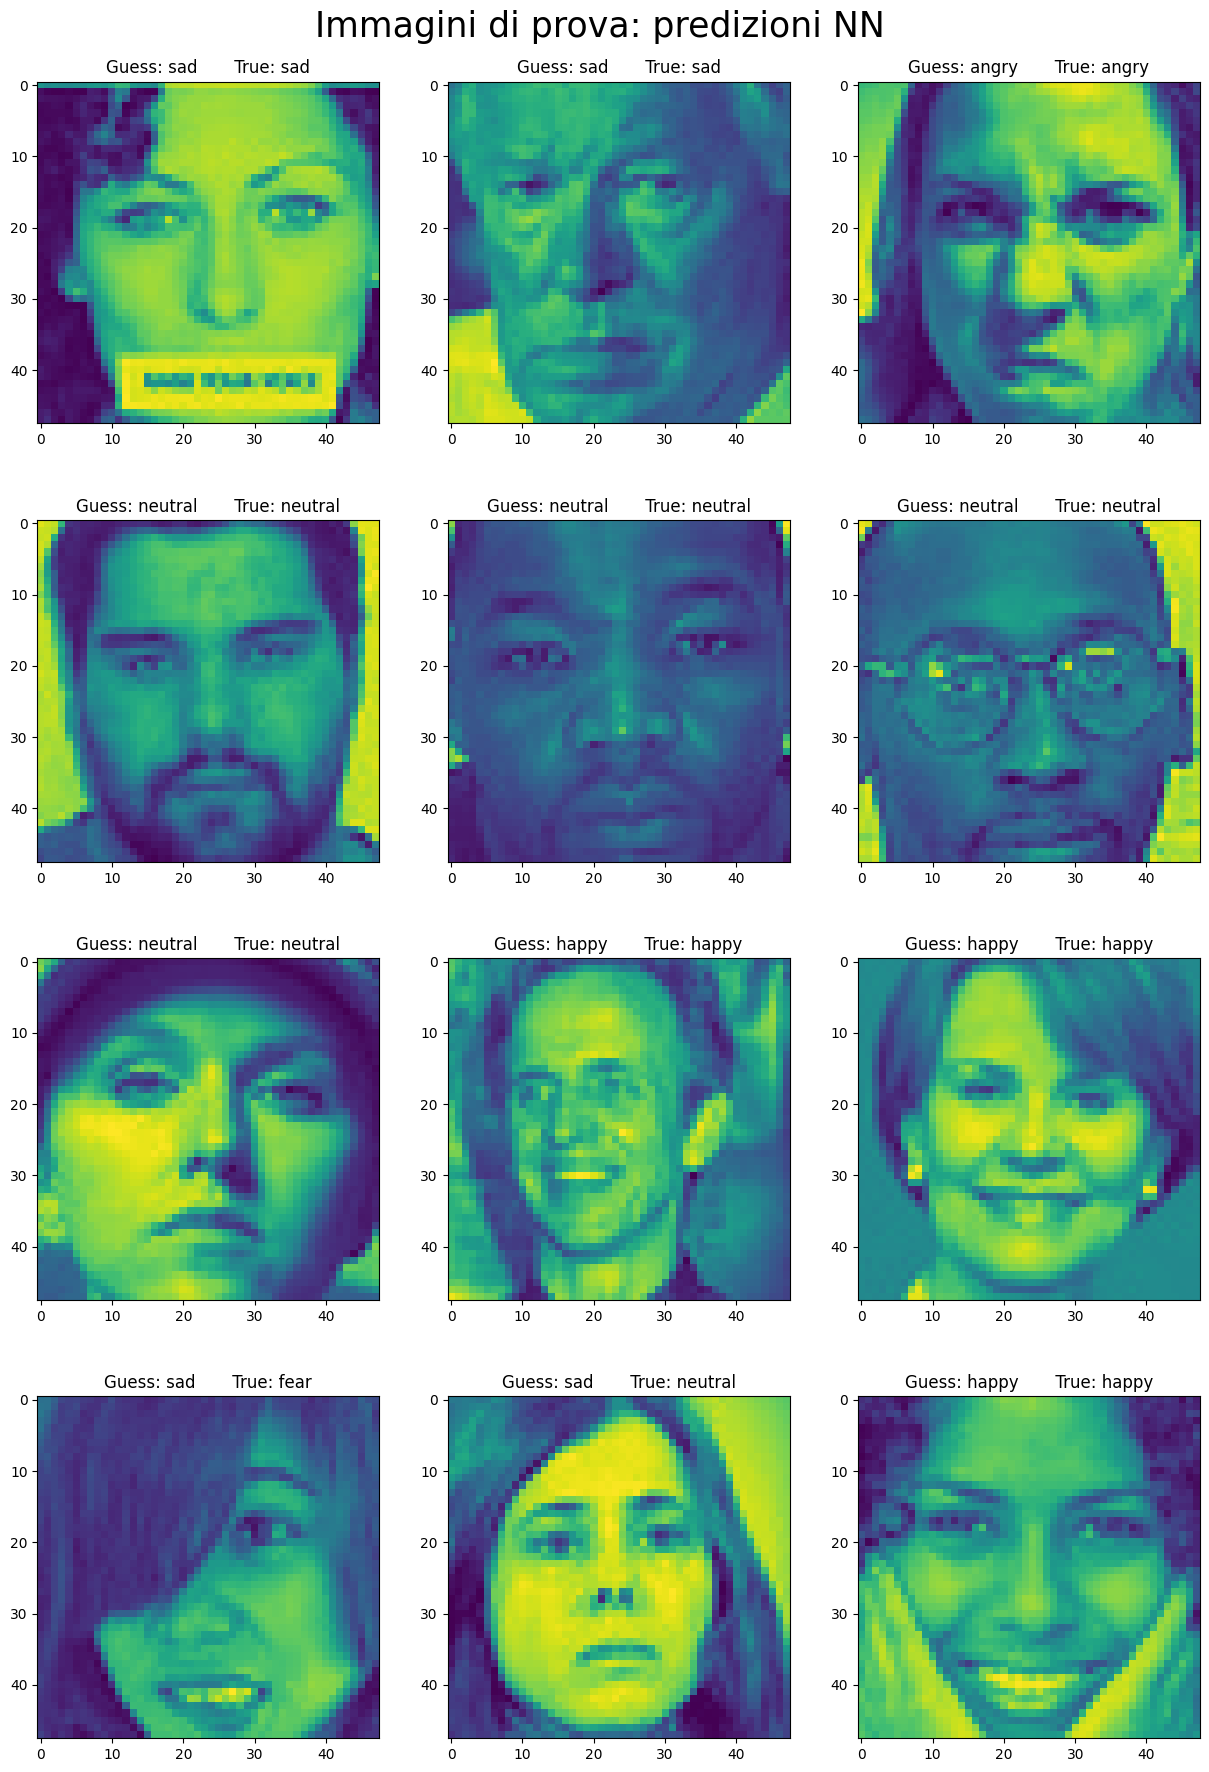

In [75]:
# Funzione per fare delle guess con la rete neurale
def studyPred(model, valDat, titles):

    # Estraggo le immagini e le labels
    images, labels = next(valDat)

    # Funzione per verificare predizioni del modello e posizionamento della bounding box
    fig, ax = plt.subplots(4, 3, figsize = (15, 20))
    for i in range(0, 4):
        for j in range(0, 3):
            # Faccio la predizione dell'immagine
            pred = model.predict(np.expand_dims(images[3*i+j, :, :], axis= 0))

            ax[i][j].imshow(images[3*i+j, :, :])
            ax[i][j].set_title("Guess: " + titles[np.argmax(pred)]+ "       True: " + titles[np.argmax(labels[3*i+j])])

    fig.suptitle("Immagini di prova: predizioni NN", fontsize = 25)
    plt.subplots_adjust(top=0.95)
    plt.show()


cls = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
studyPred(model, valDat, cls)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


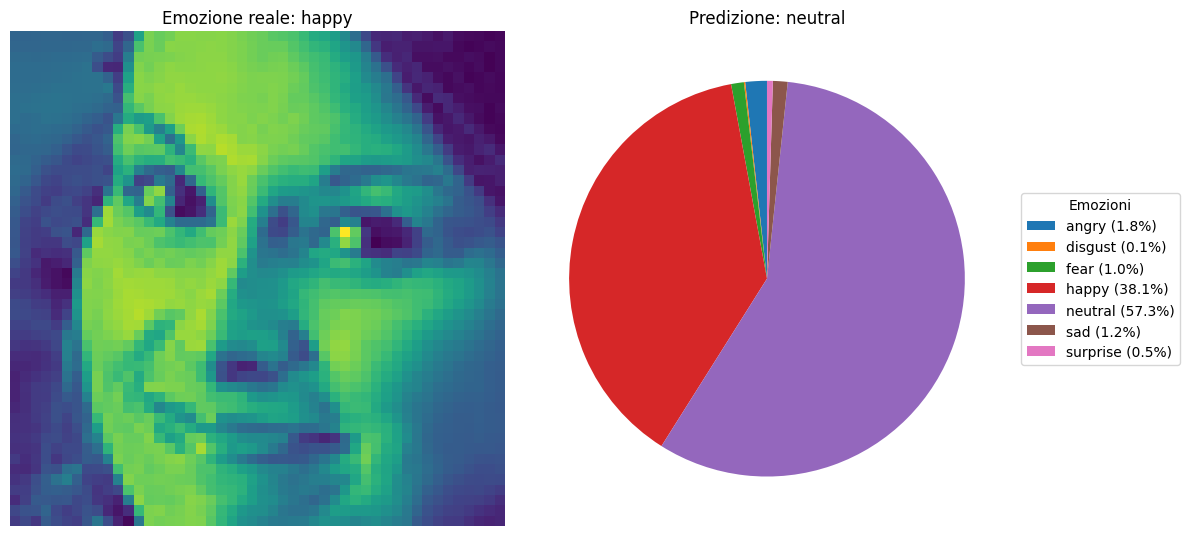

In [ ]:
# Funzione per mostrare le probabilità di appartenenza alle varie classi
def probGuess(img, lab, pred, cls):
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    # Primo subplot: mostro l'immagine con cui abbiamo a che fare
    axs[0].imshow(img)
    axs[0].axis('off')
    axs[0].set_title("Emozione reale: " + cls[np.argmax(lab)])

    # Secondo plot: grafico a torta per studio guess
    pieLab = [f"{cls[i]} ({pred[0][i]*100:.1f}%)" for i in range(len(cls))]

    fette, texts = axs[1].pie(pred[0], startangle=90)                   # Creo grafico a torta, ritorna 2 liste: fette e scritte testuali
    axs[1].legend(fette, pieLab,                                        # Assegno legenda alle varie fette in modo che non si sovrapponga
                  title="Emozioni",                                     # per mantenere la leggibilità della guess
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))
    axs[1].set_title("Predizione: " + cls[np.argmax(pred)])

    plt.tight_layout()
    plt.show()


img, lab = next(valDat)
pred = model.predict(np.expand_dims(img[0], axis=0))
cls = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

probGuess(img[0], lab[0], pred, cls)

## Esporto modello

In [ ]:
model.save("../Modelli/dropoutTry.keras")